In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

import sys
p = "../../"
sys.path.append(p)
from tools.mydedalustools import calc_helmholtz, open_h5s, concat_levels

SNAPSHOTS_DIR = "/Users/qnicolas/stationaryWave/data/"

import cartopy.crs as ccrs

%load_ext autoreload
%autoreload 2

In [3]:
def add_wind(ax,u,v,scale=None,key=True,ref=1,unit='m/s',keypos=(0.93,0.95),nm=1):
    """Adds a quiver plot to a matplotlib axis"""
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=nm;m=nm
    Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m],color="k",scale=scale,transform=ccrs.PlateCarree())
    if key:
        ax.quiverkey(Q, *keypos, ref, label='%i %s'%(ref,unit), labelpos='E', coordinates='axes',color='k')

def wrap_lon(ds,lon='lon'):
    """Add missing longitude point to the dataset by wrapping it around."""
    try: 
        ds[lon]
    except KeyError:
        lon = 'longitude'
    return ds.pad({lon:1}, mode="wrap").assign_coords({lon:ds[lon].pad({lon:1}, mode="reflect", reflect_type="odd")})

def quickplot(field, levels=None, cmap='RdBu_r', ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(15, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
    field = wrap_lon(field)
    field.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), levels=levels, cmap=cmap, extend='both')
    ax.coastlines()
    return ax

def prime(field):
    """
    Remove the zonal mean from a field.
    """
    try:
        return field - field.mean('longitude')
    except AttributeError:
        return field - field.mean('lon')
    
def lon_180_to_360(da,longitude='longitude'):
    try:
        da[longitude]
    except KeyError:
        longitude = 'lon'
    da.coords[longitude] = da.coords[longitude] % 360
    da = da.sortby(da[longitude])
    return da

def lon_360_to_180(da,longitude='longitude'):
    try:
        da[longitude]
    except KeyError:
        longitude = 'lon'
    da.coords[longitude] = (da.coords[longitude]+180) % 360 - 180
    da = da.sortby(da[longitude])
    return da

In [39]:
def process_sim(snapshot_id,N=14, sigma_full = 'default',avg = np.array([20,30])):
    sim = open_h5s(snapshot_id,('s1',),SNAPSHOTS_DIR=SNAPSHOTS_DIR)
    if sigma_full=='default':
        dsigma = np.array([0.,0.03,0.041,0.06,0.079,0.094,0.102,0.108,0.109,0.105,0.097,0.082,0.057,0.029,0.007])
        sigma_full = np.cumsum(dsigma)
    elif sigma_full=='24levs':
        sigma_full = np.array([0.00000,0.0200000,0.0300000,0.0450000,0.0600000,
              0.0800000,0.0900000,0.110000,0.130000,0.150000,
              0.170000,0.210000,0.245000,0.290000,0.340000,
              0.400000,0.470000,0.550000,0.650000,0.745000,
              0.830000,0.900000,0.955000,0.985000,1.00000,
              ])
    sim = concat_levels(sim ,N, sigma_full=sigma_full)

    for var in sim.data_vars:
        test = sim[var].isel(t=0,longitude=slice(1,None))
        if np.sum(np.isnan(test.data)) == len(test.data.flatten()): # Then this variable is a basic state variable
            sim[var] = sim[var].isel(t=0,longitude=0)
    return sim
    sim_mean = sim.sel(t=slice(*(avg*24))).mean('t').transpose('','latitude','longitude','sigma','sigma_stag')

    for var in ['u','T','lnps','zeta','sigmadot','Phiprime','div']:
        sim[var+'_mean'] = sim_mean[var]

    return sim.transpose('t','','latitude','longitude','sigma','sigma_stag')


# Making a basic state

In [71]:
basic_state = xr.open_dataset('ncep_jan_basic_state.nc')
forcing = xr.open_dataset('ncep_jan_forcings.nc')

In [76]:
nlat = 181
npres = 51
vars = ['U', 'V', 'W', 'T']
basic_state_skeleton = xr.Dataset({var: (['pressure', 'lat'], np.zeros((npres, nlat))) for var in vars}, coords = {'pressure': np.linspace(0, 1e3, npres), 'lat': np.linspace(-90, 90, nlat)})

basic_state_skeleton['SP'] = (['lat',], np.zeros((nlat)))

In [78]:
# Basic state surface pressure profile
ps = 1e3
basic_state_skeleton['SP'][:] = ps * 1e2

# Basic state Temperature profile
p = basic_state_skeleton.pressure
Ts = 300; 
gamma = 5e-5
kappa = 287/1004
const = 1 + gamma * ps ** 2 / (Ts * (2-kappa))
basic_state_skeleton['T'] = const * Ts * (p / ps) ** kappa - gamma * p ** 2 / (2-kappa) * basic_state_skeleton.lat ** 0

Text(0, 0.5, 'Pressure (hPa)')

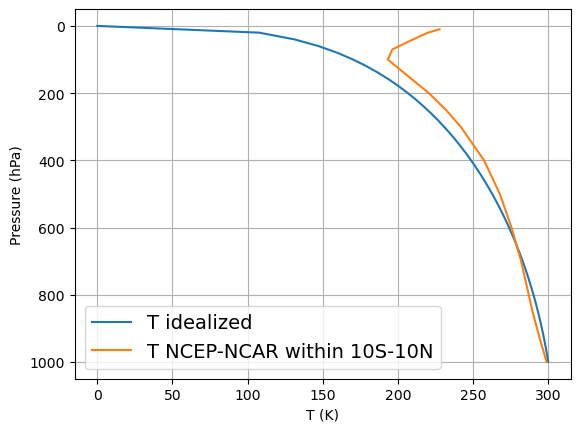

In [79]:
basic_state_skeleton['T'].sel(lat = slice(-10,10)).mean('lat').plot(y = 'pressure', yincrease=False, label='T idealized')
basic_state.T.sel(lat = slice(10,-10)).mean('lat').plot(y = 'pressure', yincrease=False, label='T NCEP-NCAR within 10S-10N')
plt.grid()
plt.legend(fontsize=14)
plt.xlabel('T (K)')
plt.ylabel('Pressure (hPa)')

In [87]:
vars = ['QDIAB', 'EHFD', 'EMFD_U', 'EMFD_V']
forcing_skeleton = xr.Dataset({var: (['pressure', 'lat', 'lon'], np.zeros((npres, nlat, 2*nlat-1))) for var in vars}, coords = {'pressure': np.linspace(0, 1e3, npres), 'lat': np.linspace(-90, 90, nlat), 'lon': np.linspace(-180, 180, 2*nlat-1)})
vars_sfc = ['ZSFC', 'SP']
for var in vars_sfc:
    forcing_skeleton[var] = (['lat','lon'], np.zeros((nlat, 2*nlat-1)))
forcing_skeleton['SP'][:] = ps * 1e2

In [88]:
# calculate Kn, then equatorial Rossby radius
Kn = np.pi**2 / (287. * gamma * ps ** 2)
cn = np.sqrt(1/Kn)
R_earth = 6.37122e6  # Earth radius in meters
beta = 2 * 2 * np.pi / 86400 / R_earth
Leq = np.sqrt(cn / (2*beta))

# Calculate diabatic heating structure
vert_structure = p * np.sin(np.pi * p / ps); vert_structure = vert_structure / vert_structure.max()
lon = forcing_skeleton.lon; lat = forcing_skeleton.lat
dlon = 20
lon_structure = np.cos(np.pi * (lon-90)/2/dlon) * (np.abs((lon-90)/dlon) < 1)
lat_structure = np.exp( - (R_earth * lat * np.pi / 180 / Leq)**2 / 4)
forcing_skeleton['QDIAB'] = 1e-2 / 86400 * vert_structure * lat_structure * lon_structure #1e-2 / 86400 *

In [89]:
vert_structure = p * np.sin(np.pi * p / ps)
vert_structure.max()

<xarray.DataArray 'pressure' ()> Size: 8B
array(579.08931358)

Text(0.5, 1.0, 'Horizontal structure of QDIAB at 650 hPa')

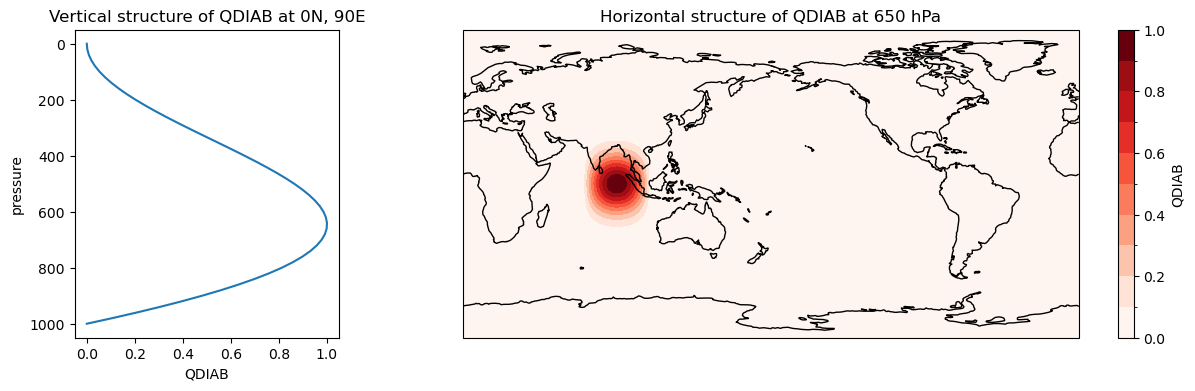

In [91]:
# use gridspec to plot one panel with the vertical structure, one with the horizontal structure
import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=(1, 3))
ax1 = fig.add_subplot(gs[0])
(forcing_skeleton.QDIAB / forcing_skeleton.QDIAB.max()).sel(lat=0,lon=90,method='nearest').plot(ax=ax1, y='pressure',yincrease=False)
ax1.set_title('Vertical structure of QDIAB at 0N, 90E')
ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
(forcing_skeleton.QDIAB / forcing_skeleton.QDIAB.max()).sel(pressure=650,method='nearest').plot.contourf(ax=ax2, cmap='Reds', levels=np.linspace(0., 1., 11), transform=ccrs.PlateCarree())
ax2.coastlines()
ax2.set_title('Horizontal structure of QDIAB at 650 hPa')

In [93]:
basic_state_skeleton.to_netcdf('ideal_Gill_basic_state.nc')
forcing_skeleton.to_netcdf('ideal_Gill_forcings.nc')

In [75]:
forcing_skeleton

<xarray.Dataset> Size: 108MB
Dimensions:   (pressure: 51, lat: 181, lon: 361)
Coordinates:
  * pressure  (pressure) float64 408B 0.0 20.0 40.0 60.0 ... 960.0 980.0 1e+03
  * lat       (lat) float64 1kB -90.0 -89.0 -88.0 -87.0 ... 87.0 88.0 89.0 90.0
  * lon       (lon) float64 3kB -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
Data variables:
    QDIAB     (pressure, lat, lon) float64 27MB -0.0 -0.0 -0.0 ... 0.0 0.0 0.0
    EHFD      (pressure, lat, lon) float64 27MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EMFD_U    (pressure, lat, lon) float64 27MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    EMFD_V    (pressure, lat, lon) float64 27MB 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ZSFC      (lat, lon) float64 523kB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    SP        (lat, lon) float64 523kB 1e+05 1e+05 1e+05 ... 1e+05 1e+05 1e+05

## Transform into Bill-compatible version

In [345]:
forcing_Gill = xr.open_dataset('ideal_Gill_forcings.nc')
forcing_Gill = lon_180_to_360(forcing_Gill['QDIAB'].rename(pressure='pre'))
forcing_Gill = wrap_lon(forcing_Gill).isel(lon=slice(1,None))
forcing_Gill.to_netcdf('ideal_Gill_QDIAB_forBill.nc')

In [ ]:
def adapt_basic_state(basic_state):
    """
    Transform the basic state to be compatible with Bill.
    """
    basic_state = basic_state.rename(pressure='pre')
    basic_state = basic_state.expand_dims({'lon':145}).assign_coords(lon=np.linspace(0,360,145)).transpose('pre','lat','lon')
    basic_state = basic_state.rename(U='u', V='v', W='w', T='t', SP='ps')
    basic_state['ps'] = basic_state.ps.expand_dims({'time':1})
    return basic_state

# basic_state_Gill = xr.open_dataset('ideal_Gill_basic_state.nc')
# basic_state_Gill['T'][:] = np.maximum(basic_state_Gill['T'].data,150)
# basic_state_Gill = adapt_basic_state(basic_state_Gill)
# basic_state_Gill.to_netcdf("ideal_Gill_basic_state_forBill.nc")

# Shallow water problem

In [5]:
snapshot_id = 'stationarywave_SW_ideal_Gill'
gill = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill_mean = gill.sel(t=slice(400,None)).mean('t').transpose('','latitude','longitude')
gill_mean = wrap_lon(gill_mean).isel(longitude=slice(1,None))

In [6]:
snapshot_id = 'stationarywave_SW_T32_ideal_Gill_nozm'
gill_SW_T32 = open_h5(snapshot_id,'s1',SNAPSHOTS_DIR=SNAPSHOTS_DIR)
gill_SW_T32_mean = gill_SW_T32.sel(t=slice(400,None)).mean('t').transpose('','latitude','longitude')
gill_SW_T32_mean = wrap_lon(gill_SW_T32_mean).isel(longitude=slice(1,None))

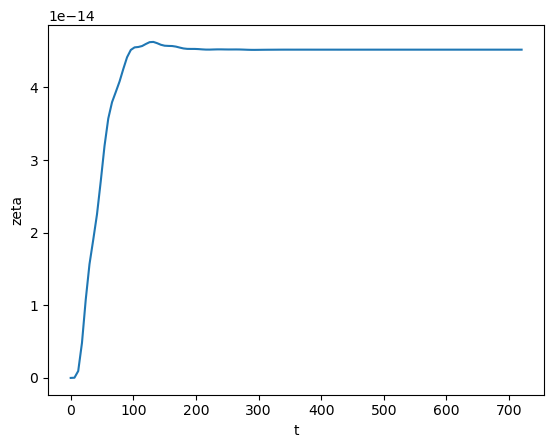

In [64]:
# Evolution of the mean enstrophy
(gill.zeta**2).mean(('latitude','longitude')).plot()

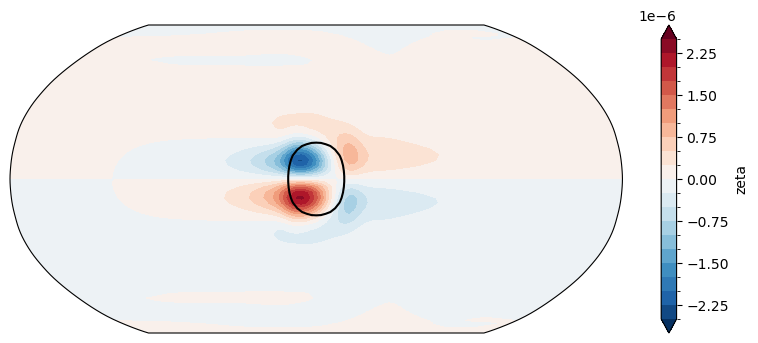

In [66]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
gill_mean.zeta.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
gill_mean.Q.plot.contour(ax=ax,levels=[5e-5],colors=['k'],transform=ccrs.PlateCarree())


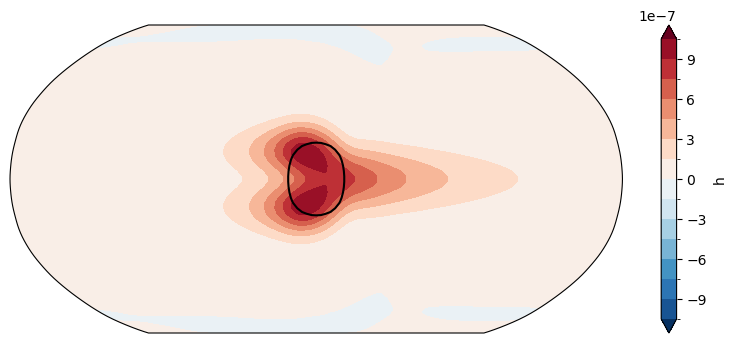

In [67]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
gill_mean.h.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
gill_mean.Q.plot.contour(ax=ax,levels=[5e-5],colors=['k'],transform=ccrs.PlateCarree())


Text(0.5, 1.0, 'divergence, wind, and heating (black contour)')

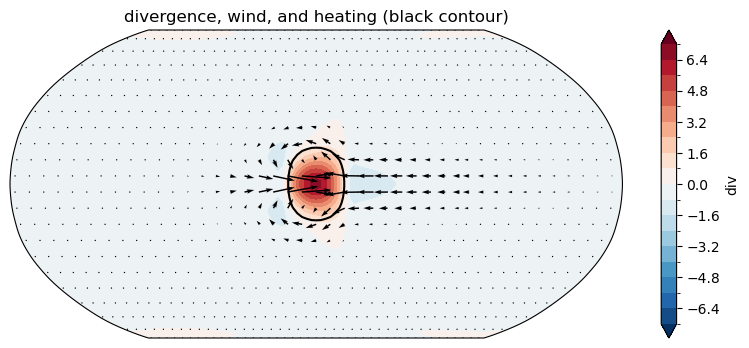

In [68]:
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
gill_mean.div.plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
gill_mean.Q.plot.contour(ax=ax,levels=[5e-5],colors=['k'],transform=ccrs.PlateCarree())

u= (gill_mean.u[0])
v=-(gill_mean.u[1])
n=3; m=n
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], -np.array(u)[::n,::m], -np.array(v)[::n,::m],color="k",transform=ccrs.PlateCarree(),scale=2e-2)

plt.title('divergence, wind, and heating (black contour)')

## Shallow water problem vs Gill solution

In [206]:
# Analytical solution from Vallis chapter 8 (p325)
Omega = 2*np.pi / 86400

ps = 1e3
gamma = 5e-5
Kn = np.pi**2 / (287. * gamma * ps ** 2)
cn = np.sqrt(1/Kn)
beta = 2 * Omega / R0
Leq = np.sqrt(cn / (2*beta))
Teq = 1/np.sqrt(2 * cn * beta)

alpha = 0.5/ 86400 * Teq # nondim damping

L = R0 * 20 * np.pi / 180. / Leq # nondim length scale of forcing
A_dim = 1 / 86400 / (Kn * gamma * (ps/np.pi) * 580) 
A = Leq * A_dim / cn ** 3
k = np.pi / (2*L)

lons = np.linspace(-90,269,360)
lats = np.linspace(-90,90,181)
longitude = xr.DataArray(lons, dims='longitude', coords={'longitude': lons})
latitude = xr.DataArray(lats, dims='latitude', coords={'latitude': lats})
x = (longitude - 90)* np.pi / 180. *R0 / Leq
y_dim = latitude * np.pi / 180. *R0

q0_inner = - A / (alpha**2 + k**2) * (alpha * np.cos(k*x) + k * (np.sin(k*x) + np.exp(-alpha * (x+L))))
q0_outer = - A * k / (alpha**2 + k**2) * (1 + np.exp(-2*alpha*L)) * np.exp(alpha * (L-x))
q0 = (np.abs(x) <= L) * q0_inner + (x > L) * q0_outer

q2_inner = A / ((3*alpha)**2 + k**2) * (- 3 * alpha * np.cos(k*x) + k * (np.sin(k*x) - np.exp(3 * alpha * (x-L))))
q2_outer = - A * k / ((3*alpha)**2 + k**2) * (1 + np.exp(-6*alpha*L)) * np.exp(3 * alpha * (L+x))
q2 = (np.abs(x) <= L) * q2_inner + (x < -L) * q2_outer


phi_tot = - cn**2/2 * (q0 + q2 * (1 + 2 * beta * y_dim**2/cn)) * np.exp(-beta * y_dim**2/2/cn)
phi_tot = phi_tot.transpose('latitude','longitude')

Text(0.5, 1.0, 'Difference Dedalus - analytical')

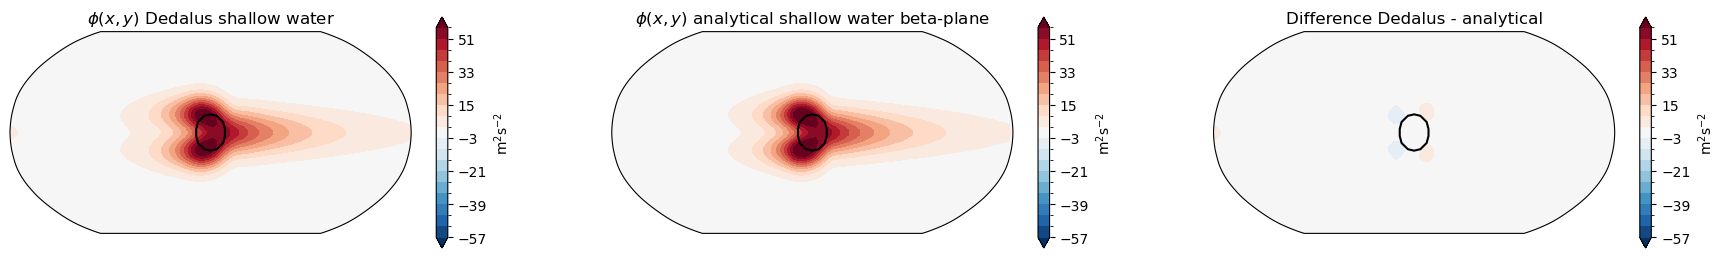

In [217]:
# Perturbation phi in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})

Phi_SW = gill_mean.h * 9.81 * 6.37122e6
phi_tot_itp = wrap_lon(lon_360_to_180(lon_180_to_360(phi_tot))).interp_like(Phi_SW)

levs = np.linspace(-1.9,1.9,20) * 30

Phi_SW.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
phi_tot_itp.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(Phi_SW - phi_tot_itp).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$\phi(x,y)$ Dedalus shallow water')
axs[1].set_title(r'$\phi(x,y)$ analytical shallow water beta-plane')
axs[2].set_title('Difference Dedalus - analytical')
# axs[1,1].remove()

# Full n-level model

In [7]:
ideal_T32 = process_sim('stationarywave_14level_T32_ideal_Gill_nozm')
ideal_T32 = wrap_lon(ideal_T32).isel(longitude=slice(1,None))

In [18]:
ideal_T32_24levs = process_sim('stationarywave_24level_T32_ideal_Gill_nozm',N=24,sigma_full='24levs')
ideal_T32_24levs = wrap_lon(ideal_T32_24levs).isel(longitude=slice(1,None))

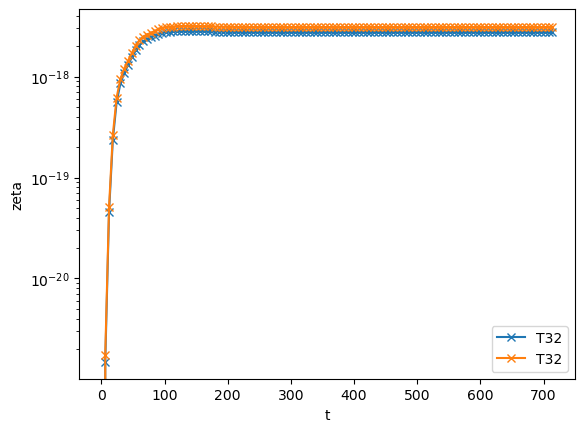

In [19]:
# CONVERGENCE
(ideal_T32.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32',marker='x' )
(ideal_T32_24levs.zeta**2).mean(('longitude','latitude','sigma')).plot(label='T32',marker='x' )

plt.legend()
plt.yscale('log')


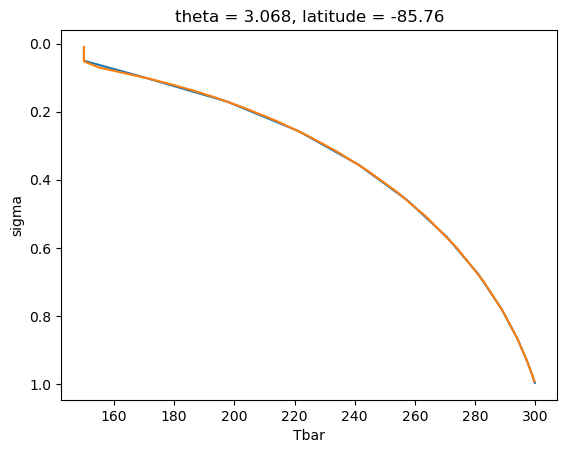

In [20]:
ideal_T32.Tbar.isel(latitude=0).plot(y='sigma',yincrease=False)
ideal_T32_24levs.Tbar.isel(latitude=0).plot(y='sigma',yincrease=False)

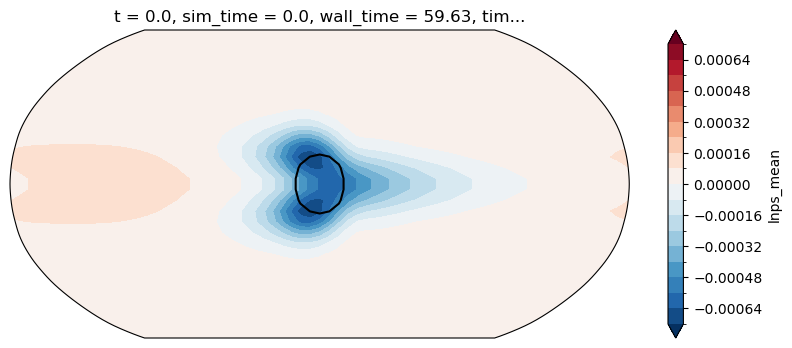

In [255]:
# Perturbation vorticity in gill run
_,ax=plt.subplots(1,1,figsize=(10,4),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
(1e2 * ideal_T32.lnps_mean).plot.contourf(ax=ax,levels=21,extend='both',transform=ccrs.PlateCarree())
ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())


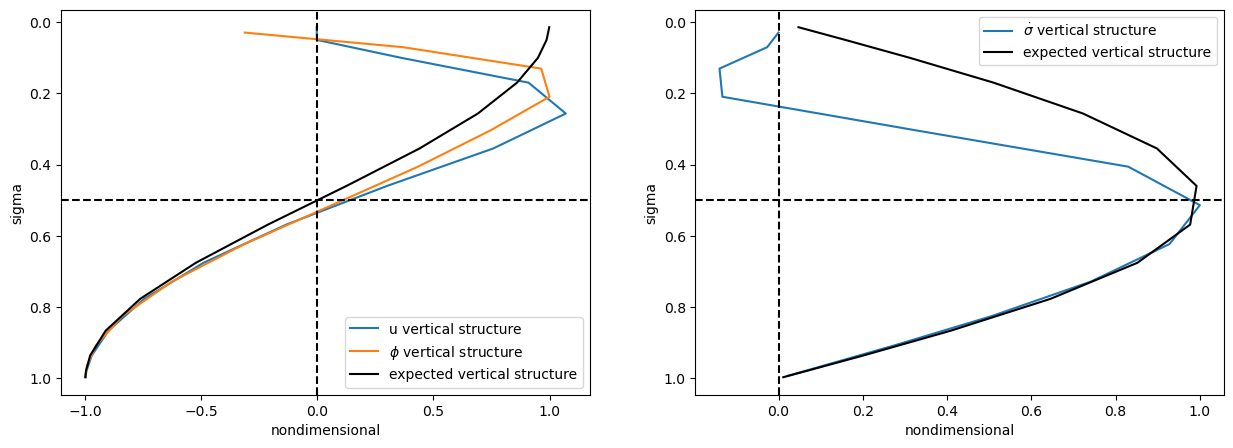

In [309]:
_,axs = plt.subplots(1,2,figsize=(15,5))

ax = axs[0]
(ideal_T32.u_mean[0]/(-ideal_T32.u_mean[0].isel(sigma=-1))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma',yincrease=False,label = 'u vertical structure')
Phiprime_test = ideal_T32.Phiprime_mean.sel(latitude = 0,longitude=110,method='nearest')
(Phiprime_test / Phiprime_test.max() * 2 - 1).plot(ax=ax,y='sigma_stag',yincrease=False,label = r'$\phi$ vertical structure')
np.cos(ideal_T32.sigma * np.pi).plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

ax = axs[1]
(ideal_T32.sigmadot_mean/(ideal_T32.sigmadot_mean.sel(sigma_stag=0.5,method='nearest'))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma_stag',yincrease=False,label = r'$\dot \sigma$ vertical structure')
np.sin(ideal_T32.sigma * np.pi).plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

for ax in axs.flatten():
    ax.axvline(0., color='k', linestyle='--')
    ax.axhline(0.5, color='k', linestyle='--')
    ax.legend()
    ax.set_xlabel('nondimensional')

Text(0.5, 1.0, 'Difference 14lev - SW')

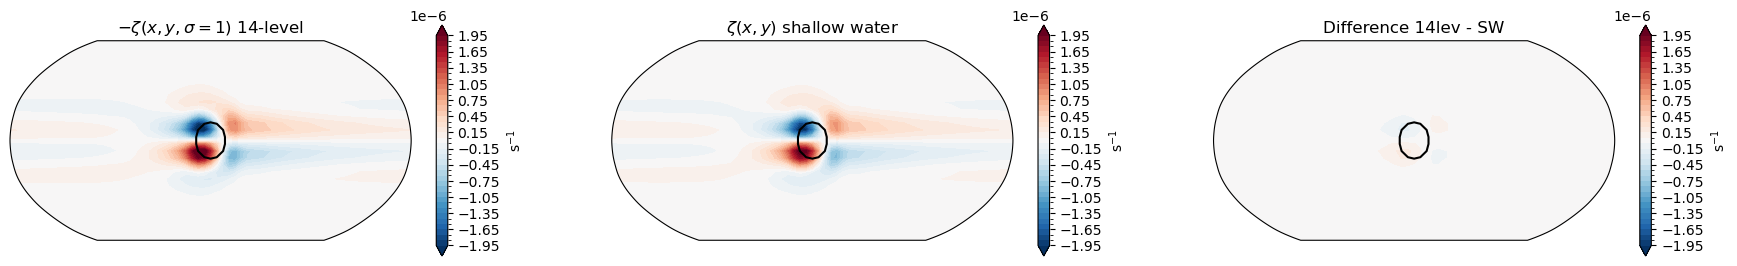

In [61]:
# Perturbation zeta in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
zeta_Nlev = 100 * (-ideal_T32.zeta_mean).sel(sigma=1,method='nearest')
zeta_SW = gill_SW_T32_mean.zeta
levs = np.linspace(-1.95,1.95,40) * 1e-6
zeta_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
zeta_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
(zeta_Nlev - zeta_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$-\zeta(x,y,\sigma=1)$ 14-level')
axs[1].set_title(r'$\zeta(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()

Text(0.5, 1.0, 'Difference 14lev - SW')

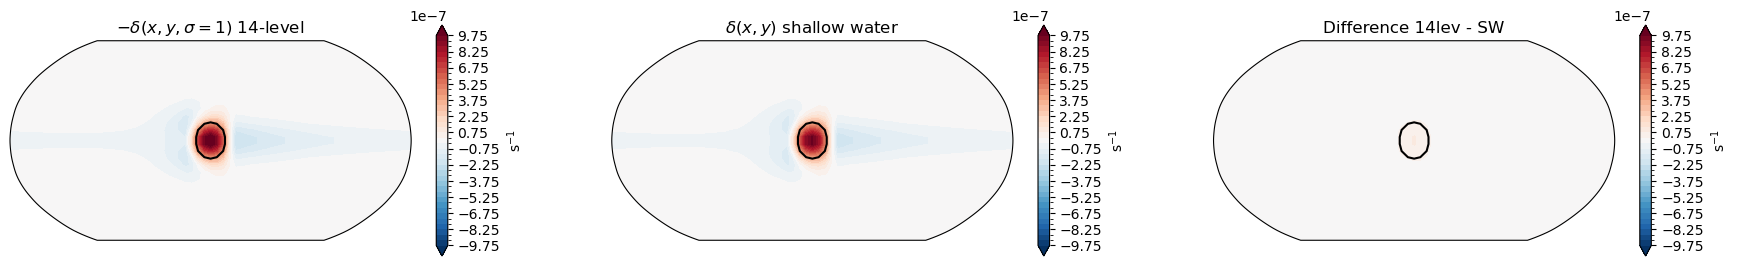

In [62]:
# Perturbation div in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
div_Nlev = 100 * (-ideal_T32.div_mean).sel(sigma=1,method='nearest')
div_SW = gill_SW_T32_mean.div
levs = np.linspace(-1.95,1.95,40) * 1e-6/2
div_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
div_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})
(div_Nlev - div_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$-\delta(x,y,\sigma=1)$ 14-level')
axs[1].set_title(r'$\delta(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()

Text(0.5, 1.0, 'Difference 14lev - SW')

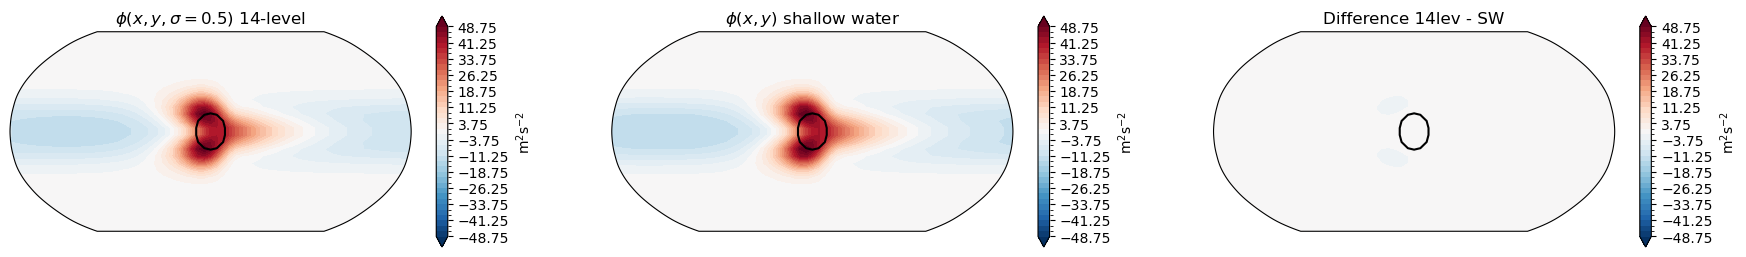

In [ ]:
# Perturbation phi in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
Phi_Nlev = 100 * (ideal_T32.Phiprime_mean).sel(sigma_stag=0.5,method='nearest')
Phi_SW = gill_SW_T32_mean.h * 9.81 * 6.37122e6
levs = np.linspace(-1.95,1.95,40) * 25
Phi_Nlev.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
Phi_SW.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(Phi_Nlev - Phi_SW).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$\phi(x,y,\sigma=0.5)$ 14-level')
axs[1].set_title(r'$\phi(x,y)$ shallow water')
axs[2].set_title('Difference 14lev - SW')
# axs[1,1].remove()

# Bill's model

In [22]:
ideal_bill = lon_360_to_180( xr.open_dataset("output_sigma_idealGill.nc").isel(T=0).rename(X='longitude', Y='latitude',lev='sigma') )

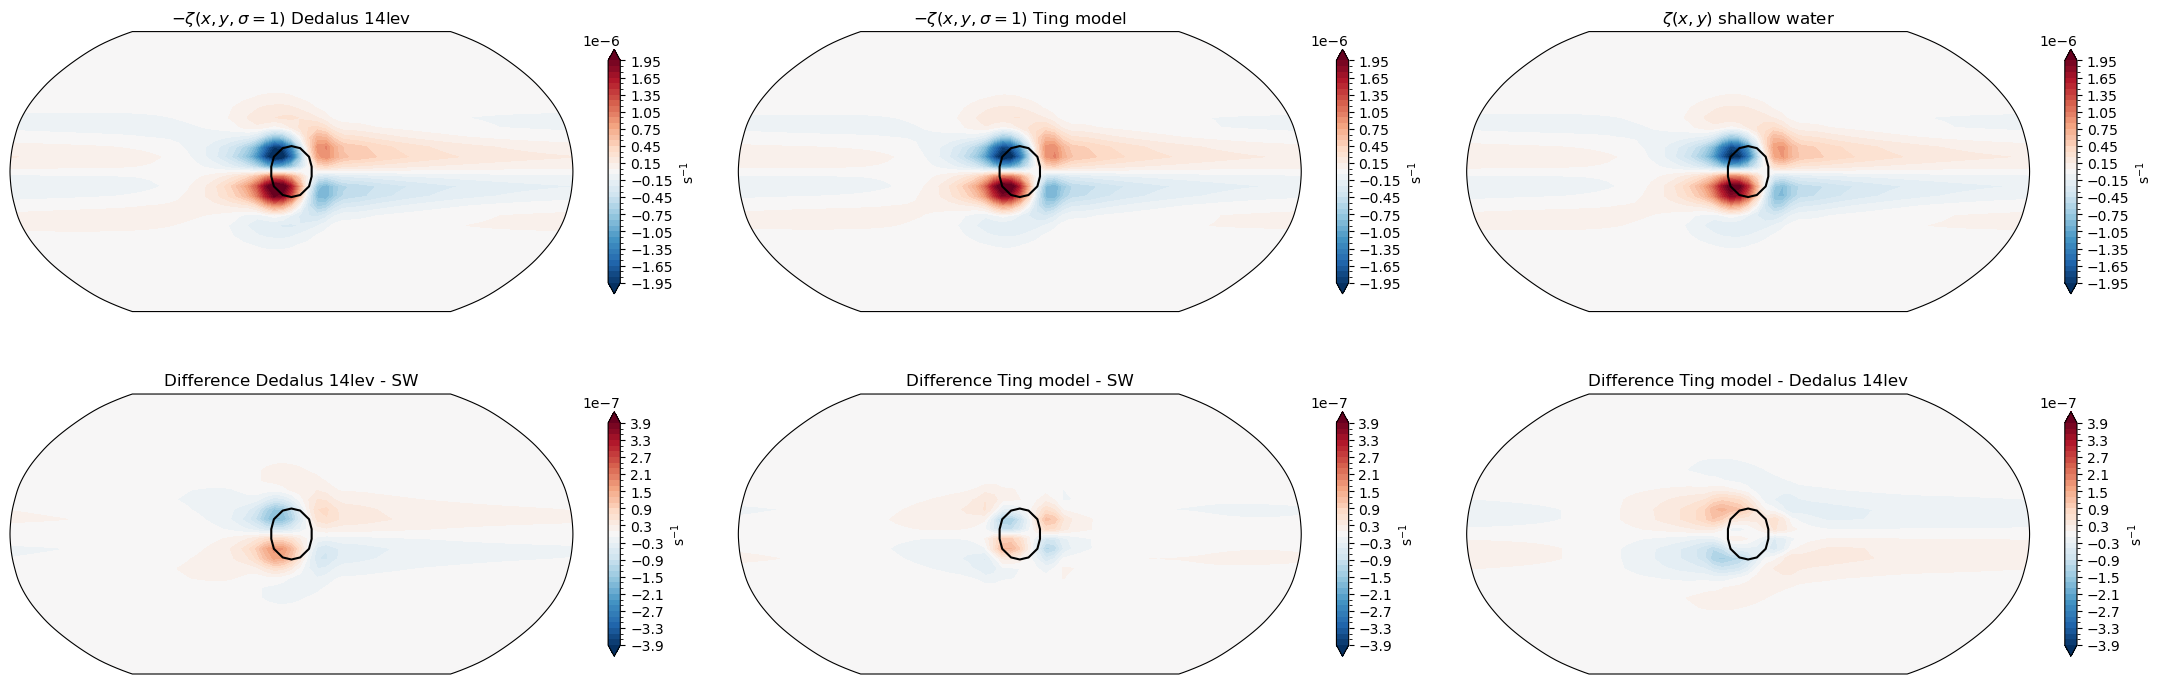

In [68]:
# Perturbation zeta in gill run
fig,axs=plt.subplots(2,3,figsize=(22,8),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})

zeta_Nlev = 100 * (-ideal_T32.zeta_mean).sel(sigma=1,method='nearest')
zeta_Nlev_2 = wrap_lon(wrap_lon(100 * (-ideal_bill.vor).sel(sigma=1,method='nearest')))
zeta_Nlev_2 = zeta_Nlev_2.interp_like(zeta_Nlev)
zeta_SW = gill_SW_T32_mean.zeta

levs = np.linspace(-1.95,1.95,40) * 1e-6
for i, zeta in enumerate([zeta_Nlev, zeta_Nlev_2, zeta_SW]):
    zeta.plot.contourf(ax=axs[0,i],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for i, zeta in enumerate([zeta_Nlev - zeta_SW, zeta_Nlev_2 - zeta_SW, zeta_Nlev_2 - zeta_Nlev]):
    (zeta).plot.contourf(ax=axs[1,i],levels=levs/5,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]/5})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0,0].set_title(r'$-\zeta(x,y,\sigma=1)$ Dedalus 14lev')
axs[0,1].set_title(r'$-\zeta(x,y,\sigma=1)$ Ting model')
axs[0,2].set_title(r'$\zeta(x,y)$ shallow water')
axs[1,0].set_title('Difference Dedalus 14lev - SW')
axs[1,1].set_title('Difference Ting model - SW')
axs[1,2].set_title('Difference Ting model - Dedalus 14lev')
fig.tight_layout()

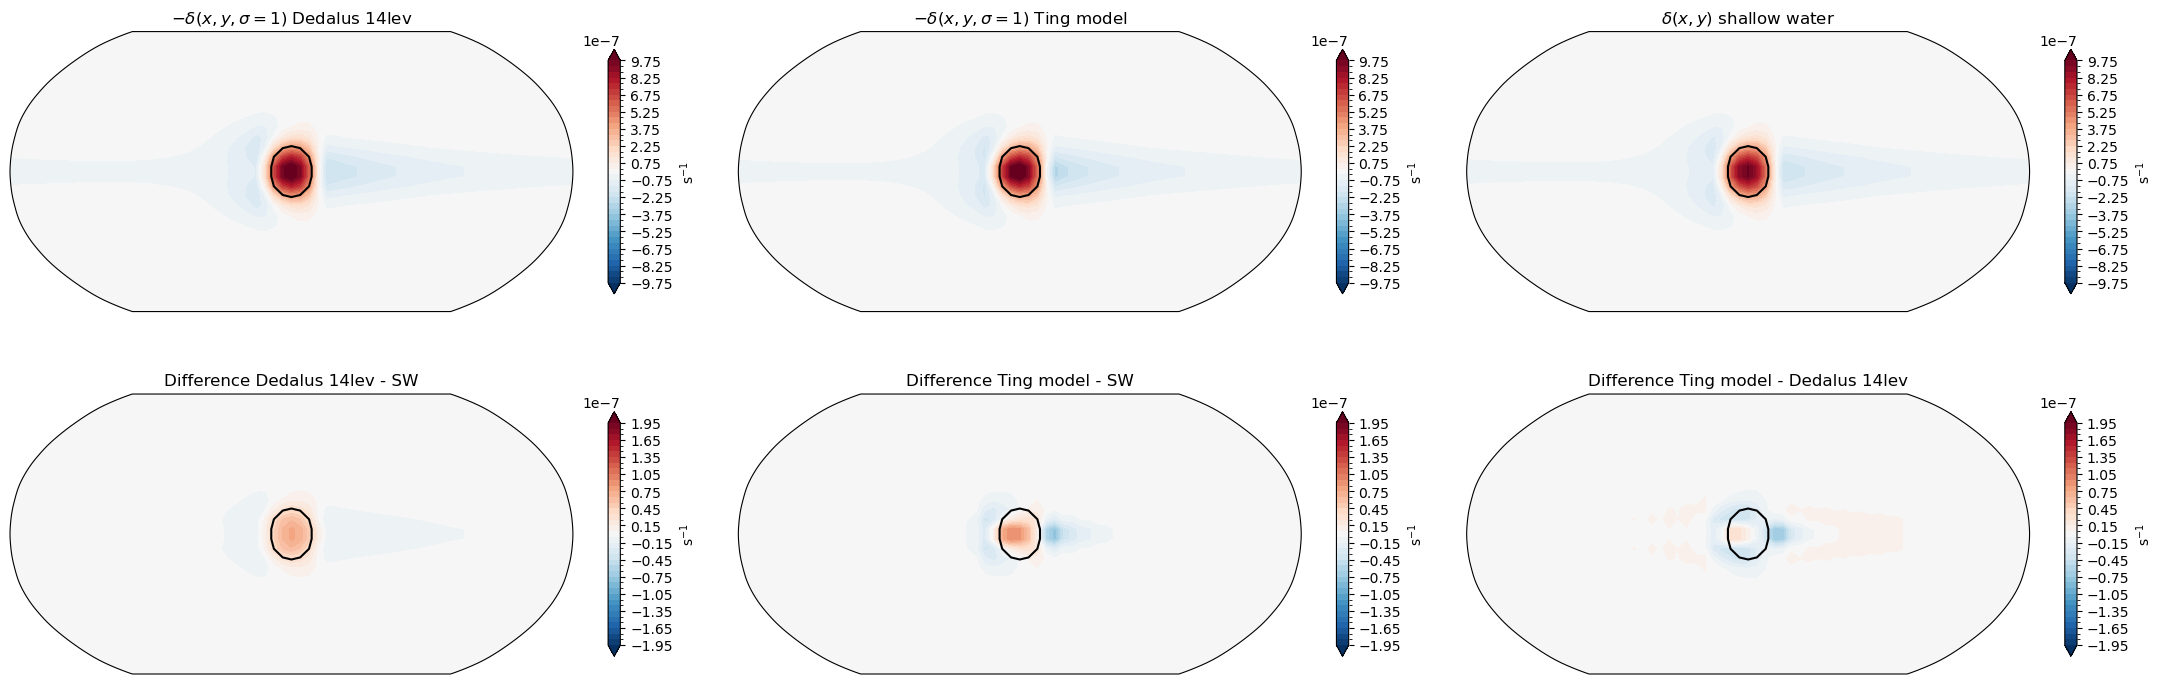

In [69]:
# Perturbation zeta in gill run
fig,axs=plt.subplots(2,3,figsize=(22,8),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})

zeta_Nlev = 100 * (-ideal_T32.div_mean).sel(sigma=1,method='nearest')
zeta_Nlev_2 = wrap_lon(wrap_lon(100 * (-ideal_bill.div).sel(sigma=1,method='nearest')))
zeta_Nlev_2 = zeta_Nlev_2.interp_like(zeta_Nlev)
zeta_SW = gill_SW_T32_mean.div

levs = np.linspace(-1.95,1.95,40) * 1e-6/2
for i, zeta in enumerate([zeta_Nlev, zeta_Nlev_2, zeta_SW]):
    zeta.plot.contourf(ax=axs[0,i],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]})

for i, zeta in enumerate([zeta_Nlev - zeta_SW, zeta_Nlev_2 - zeta_SW, zeta_Nlev_2 - zeta_Nlev]):
    (zeta).plot.contourf(ax=axs[1,i],levels=levs/5,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r's$^{-1}$','shrink':0.6,'ticks':levs[::3]/5})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0,0].set_title(r'$-\delta(x,y,\sigma=1)$ Dedalus 14lev')
axs[0,1].set_title(r'$-\delta(x,y,\sigma=1)$ Ting model')
axs[0,2].set_title(r'$\delta(x,y)$ shallow water')
axs[1,0].set_title('Difference Dedalus 14lev - SW')
axs[1,1].set_title('Difference Ting model - SW')
axs[1,2].set_title('Difference Ting model - Dedalus 14lev')
fig.tight_layout()

Text(0.5, 1.0, 'Difference Ting - Dedalus')

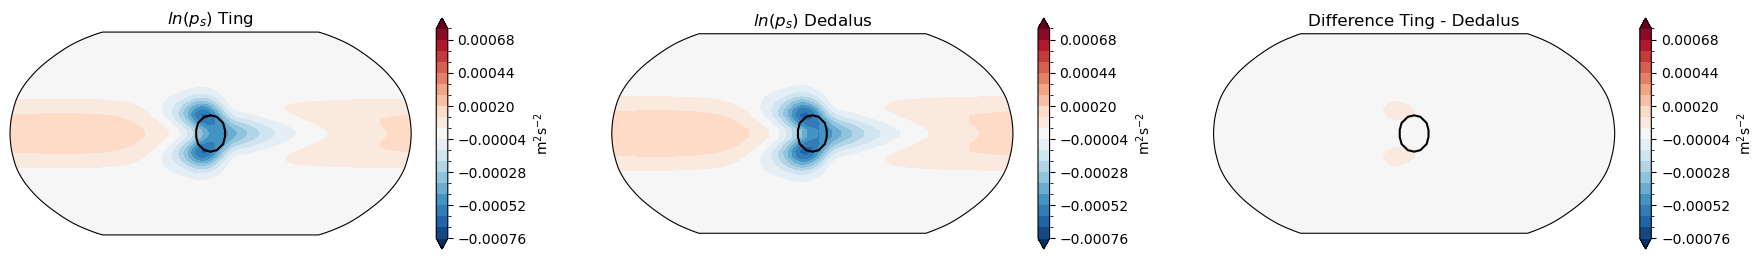

In [ ]:
# Perturbation div in gill run
_,axs=plt.subplots(1,3,figsize=(22,5),subplot_kw={'projection':ccrs.Robinson(central_longitude=90)})
lnps_Nlev_2 = wrap_lon(wrap_lon(100 * (ideal_bill.ps)))
lnps_Nlev = 100 * ideal_T32.lnps_mean
levs = np.linspace(-1.9,1.9,20) * 1e-4*4
lnps_Nlev_2.plot.contourf(ax=axs[0],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
lnps_Nlev.plot.contourf(ax=axs[1],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})
(lnps_Nlev_2.interp_like(lnps_Nlev) - lnps_Nlev).plot.contourf(ax=axs[2],levels=levs,extend='both',transform=ccrs.PlateCarree(),cbar_kwargs={'label':r'm$^2$s$^{-2}$','shrink':0.6,'ticks':levs[::3]})

for ax in axs.flatten():
    # ax.coastlines()
    ideal_T32.Qdiab.isel(t=0).sel(sigma=0.65,method='nearest').plot.contour(ax=ax,levels=[5e-8],colors=['k'],transform=ccrs.PlateCarree())

axs[0].set_title(r'$ln(p_s)$ Ting')
axs[1].set_title(r'$ln(p_s)$ Dedalus 14lev')
axs[2].set_title('Difference Ting - Dedalus 14lev')
# axs[1,1].remove()

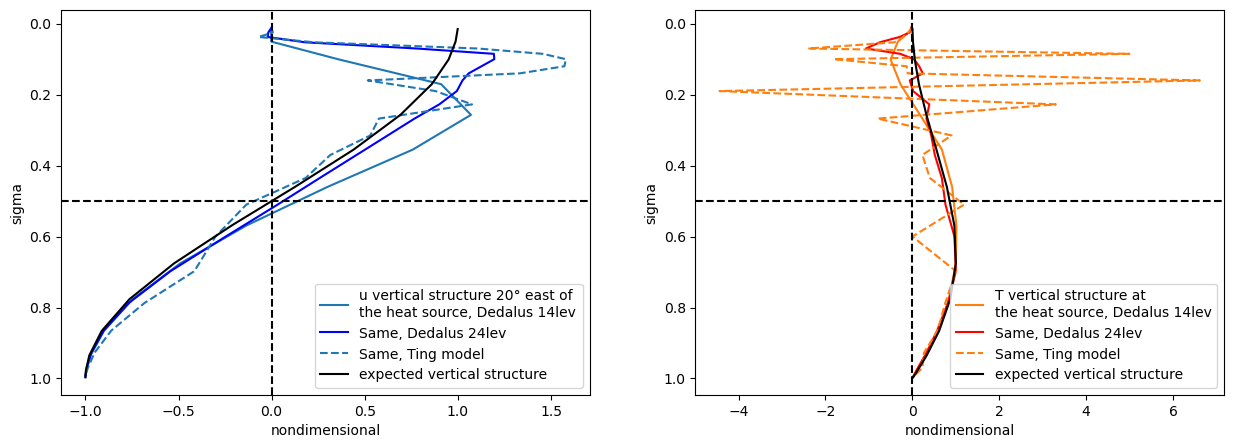

In [66]:
_,axs = plt.subplots(1,2,figsize=(15,5))

ax= axs[0]
(ideal_T32.u_mean[0]/(-ideal_T32.u_mean[0].isel(sigma=-1))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma',yincrease=False,label = 'u vertical structure 20° east of \nthe heat source, Dedalus 14lev')
(ideal_T32_24levs.u_mean[0]/(-ideal_T32_24levs.u_mean[0].isel(sigma=-1))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma',color='b',linestyle='-',yincrease=False,label = 'Same, Dedalus 24lev')
(ideal_bill.uprime/(-ideal_bill.uprime.isel(sigma=-1))).sel(latitude = 0,longitude=110,method='nearest').plot(ax=ax,y='sigma',color='C0',linestyle='--',yincrease=False,label = 'Same, Ting model')
np.cos(ideal_T32.sigma * np.pi).plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

ax=axs[1]
(ideal_T32.T_mean/(ideal_T32.T_mean.sel(sigma=0.65,method='nearest'))).sel(latitude = 0,longitude=90,method='nearest').plot(ax=ax,y='sigma',color='C1',yincrease=False,label = 'T vertical structure at \nthe heat source, Dedalus 14lev')
(ideal_T32_24levs.T_mean/(ideal_T32_24levs.T_mean.sel(sigma=0.65,method='nearest'))).sel(latitude = 0,longitude=90,method='nearest').plot(ax=ax,y='sigma',color='r',linestyle='-',yincrease=False,label = 'Same, Dedalus 24lev')
(ideal_bill.tprime/(ideal_bill.tprime.sel(sigma=0.65,method='nearest'))).sel(latitude = 0,longitude=90,method='nearest').plot(ax=ax,y='sigma',color='C1',linestyle='--',yincrease=False,label = 'Same, Ting model')
vertstruct = ideal_T32.sigma * np.sin(ideal_T32.sigma * np.pi)
vertstruct=vertstruct/vertstruct.max()
vertstruct.plot(ax=ax,y='sigma',yincrease=False,color='k',label = r'expected vertical structure')

for ax in axs.flatten():
    ax.axvline(0., color='k', linestyle='--')
    ax.axhline(0.5, color='k', linestyle='--')
    ax.legend(loc=4)
    ax.set_xlabel('nondimensional')

# Vertical structures in ideal topo case

In [40]:
ideal_topo_ncepbs_T32 = process_sim('stationarywave_14level_T32_held2002_idealorog_linear_dampedzonalmean_variablesigma_nozonalmeanforcing_cnlf2')
# ideal_topo_ncepbs_bill = xr.open_dataset("output_sigma_idealorog1pct.nc").isel(T=0).rename(X='longitude', Y='latitude',lev='sigma')

In [42]:
ideal_topo_ncepbs_T32 = ideal_topo_ncepbs_T32.sel(t = slice(20*24,None)).mean('t')

In [45]:
ideal_topo_ncepbs_bill

<xarray.Dataset> Size: 36MB
Dimensions:    (longitude: 192, latitude: 160, sigma: 24)
Coordinates:
  * longitude  (longitude) float32 768B 0.0 1.875 3.75 ... 354.4 356.2 358.1
  * latitude   (latitude) float32 640B -89.14 -88.03 -86.91 ... 88.03 89.14
  * sigma      (sigma) float32 96B 0.01 0.025 0.0375 ... 0.9275 0.97 0.9925
    T          int32 4B 12
Data variables: (12/17)
    div        (sigma, latitude, longitude) float32 3MB ...
    vor        (sigma, latitude, longitude) float32 3MB ...
    phi        (sigma, latitude, longitude) float32 3MB ...
    heating    (sigma, latitude, longitude) float32 3MB ...
    zstar      (latitude, longitude) float32 123kB ...
    ps         (latitude, longitude) float32 123kB ...
    ...         ...
    tprime     (sigma, latitude, longitude) float32 3MB ...
    tranv      (sigma, latitude, longitude) float32 3MB ...
    trand      (sigma, latitude, longitude) float32 3MB ...
    RTAU       (sigma) float32 96B ...
    DRAGU      (sigma) float32 96B ...
    DRAGV      (sigma) float32 96B ...
Attributes:
    history:                    Wed Jul 30 16:01:02 2025: ncra -A -F -d T,5,2...
    history_of_appended_files:  Wed Jul 30 16:01:02 2025: Appended file ../ou...
    NCO:                        netCDF Operators version 5.2.4 (Homepage = ht...

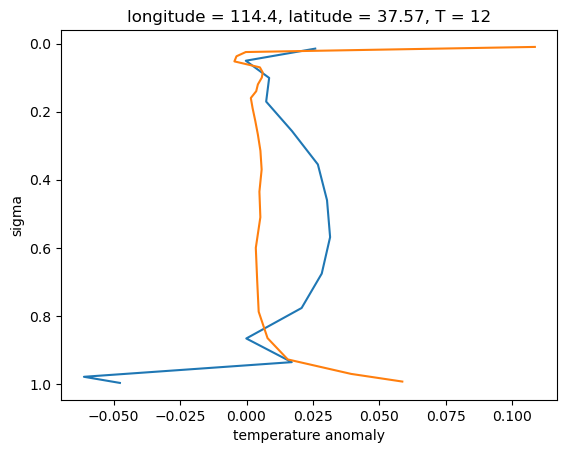

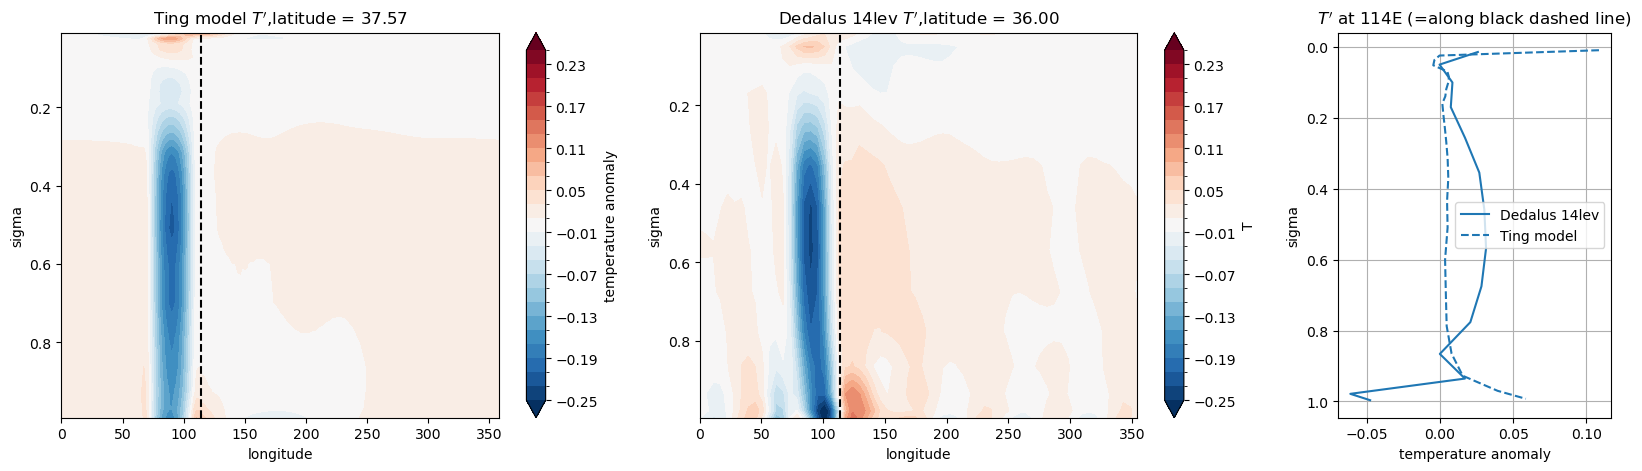

In [65]:
_,axs = plt.subplots(1,3,figsize=(20,5),width_ratios=[1,1,0.5])
ideal_topo_ncepbs_bill.sel(latitude=37.5,method='nearest').tprime.plot.contourf(ax=axs[0],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
lon_180_to_360(ideal_topo_ncepbs_T32.sel(latitude=37.5,method='nearest').T).plot.contourf(ax=axs[1],y='sigma',yincrease=False,levels = np.linspace(-0.25,0.25,26),extend='both')
for ax in axs[:2]:
    ax.axvline(114.,color='k',linestyle='--')

axs[0].set_title(r"Ting model $T'$," + "latitude = %.2f"%ideal_topo_ncepbs_bill.sel(latitude=37.5,method='nearest').latitude.data)
axs[1].set_title(r"Dedalus 14lev $T'$," + "latitude = %.2f"%ideal_topo_ncepbs_T32.sel(latitude=37.5,method='nearest').latitude.data)

ideal_topo_ncepbs_T32.T.sel(latitude=37.5,longitude=114,method='nearest').plot(ax=axs[2],y='sigma',yincrease=False, label='Dedalus 14lev')
(ideal_topo_ncepbs_bill.tprime).sel(latitude=37.5,longitude=114,method='nearest').plot(ax=axs[2],y='sigma',color='C0',linestyle='--',yincrease=False, label='Ting model')

axs[2].set_title(r"$T'$ at 114E (=along black dashed line)")
axs[2].grid()
axs[2].legend()